#### Lee Lab Interview Notebook

In this notebook, we briefly explore several different methods of performing 2D image registration, in increasing order of difficulty

##### Setup

In [94]:
import os
import numpy
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# TODO: please only use NumPy and SciPy packages for the following exercises, but feel free to import any missing NumPy or SciPy subpackages here

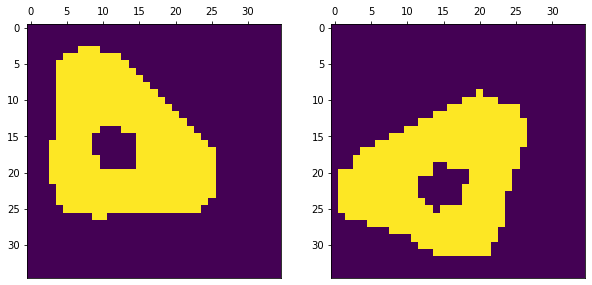

In [186]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)

def check_results(img1, img2, points1 = [], points2 = []):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(img1); ax1.xaxis.tick_top()
    ax2.imshow(img2); ax2.xaxis.tick_top()
    for p1, p2 in zip(points1, points2):
        fig.add_artist(ConnectionPatch(p1, p2, 'data', 'data', axesA=ax1, axesB=ax2, mutation_scale = 20, color = 'green', arrowstyle='-|>'));

check_results(source_img, target_img)

##### Method 1: Brute force alignment
This brute force method should iterate through all angles and computes the mean squared error between the transformed source image and the target image. We simply pick the angle with the minimum mean-squared error.

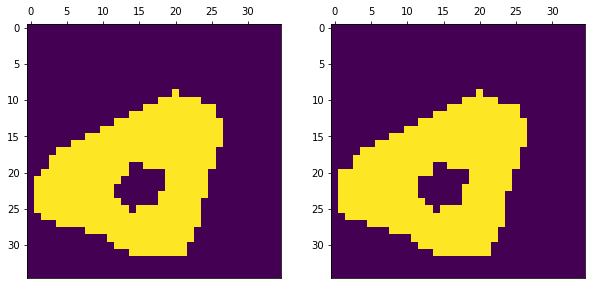

In [96]:
def apply_angle(img, angle):
    return scipy.ndimage.rotate(img, angle, reshape = False)

def calc_mse(img1, img2):
    # mean-squared error between the two images
    mse = ((img1 - img2) ** 2).mean()
    return mse

angles = np.linspace(0, 360, num = 200)
mse_vals = np.zeros(angles.shape)

for idx, angle in enumerate(angles):
    # rotate `source_img`, compute mean-squared error, and save result
    rotated_img = apply_angle(source_img, angle)
    mse_vals[idx] = calc_mse(rotated_img, target_img)

## for plotting mse vs. angle
# plt.figure(figsize=(5,5))
# plt.plot(angles, mse_vals);
# plt.xlabel('angle');
# plt.ylabel('mse');

# pick angle corresponding to the lowest mean squared error
optim_angle = angles[np.argmin(mse_vals)]

source_img_tx1 = apply_angle(source_img, optim_angle)
check_results(source_img_tx1, target_img)

##### Method 2: Least squares

Although the brute force approach works, it is obviously not the optimal approach, especially if the images are more deformed/translated/scaled than this toy example. Instead, if we manually define a few pairs of points that match between the two images, we can use a least squares approach to compute a linear transformation matrix that transforms points from the source to the target image

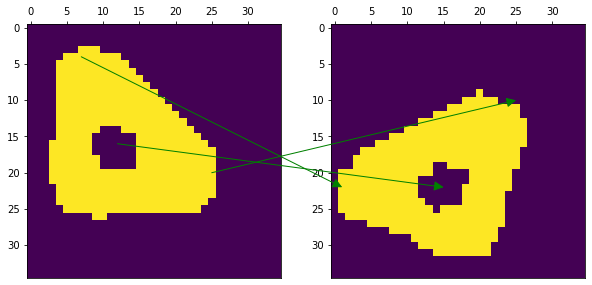

In [97]:
## Show the mapping between the 3 source points and the 3 target points
source_points = [(12,16),(7,4),(25,20)]
target_points = [(15,22),(1,22),(25,10)]
check_results(source_img, target_img, points1 = source_points, points2 = target_points)

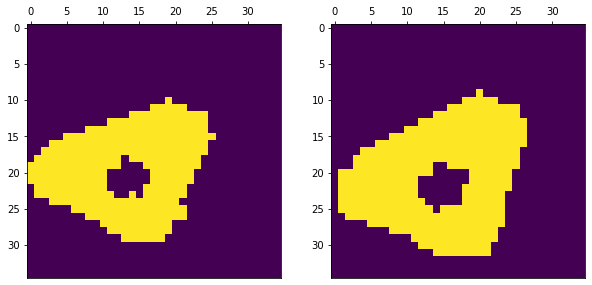

In [237]:
###########################################################################
# Compute transformation matrix using `source_points` and `target_points` #
###########################################################################

from scipy.optimize import least_squares

source_points = np.array([(12,16),(7,4),(25,20)])
target_points = np.array([(15,22),(1,22),(25,10)])

# Defining the function that calculates the residuals
def transformation_matrix(params, source_points, target_points):
    a, b, tx, c, d, ty = params # Separating the parameters
    source_x, source_y = source_points.T 
    target_x, target_y = target_points.T 
    transformed_x = a*source_x + b*source_y + tx
    transformed_y = c*source_x + d*source_y + ty
    residuals = np.concatenate((transformed_x - target_x, transformed_y - target_y))
    return residuals

# Setting the initial guess for the transformation matrix (e.g., identity)
x0 = np.array([1, 0, 0, 0, 1, 0])

# Using the least squares method to find the best-fit transformation matrix
trans_matrix = least_squares(transformation_matrix, x0, args=(source_points, target_points)).x
# Reshaping the transformation matrix to a 3x3 matrix
trans_matrix = np.vstack((trans_matrix.reshape(2,3), 
                          [0, 0, 1])) # Preserves collinearity in the affine transformation

###############################################################
# Apply the optimal affine transformation to the source image #
###############################################################

source_img_tx2 = scipy.ndimage.affine_transform(source_img, trans_matrix)

check_results(source_img_tx2, target_img)


##### Method 3: Optimization

If we don't have a list of points but still want a transformation matrix, an alternative is an optimization approach, such as gradient descent. 
We need to first define a similarity metric to minimize between the two images (for example: mean-squared error), and then we compute the gradient of this metric with respect to each of our transformation matrix elements. In each iteration of this algorithm, we apply an update to each matrix element based on the gradient value. 

You can read more about SciPy's built-in optimizers here
https://docs.scipy.org/doc/scipy/tutorial/optimize.html

### Answer: (1) explanation, (2) challenges, and (3) code: 

In this code, I used the minimize function from the scipy.optimize library to compute an optimal affine transformation matrix that aligns the source image with the target image without using any matching points.

First, I defined two functions: mse and jac. The "mse" function takes in the current set of transformation parameters (a, b, c, d, tx, and ty), the source image, and the target image. It computes the mean squared error (MSE) between the transformed source image and the target image. The function then returns this MSE value.

The "jac" function takes in the same set of parameters, source image and target image as mse function. It computes the partial derivatives of the MSE with respect to each parameter and returns them in the form of a Jacobian matrix.

Then, I set an initial guess for the transformation parameters, which is the identity matrix in this case. Then, in the "minimize" function, I passed the mse function and the initial guess along with the source and target images as arguments, and set the jac function as the Jacobian of the gradient. The minimize function then performs an optimization algorithm (BFGS) to find the set of parameters that minimize the MSE.

Finally, by creating the optimal affine transformation matrix using the values of the optimized parameters, I applied this transformation to the source image, resulting in the source_img_tx3.

P.S: However,the final transfomed image has not converged well even though I tried several diffrent situations and try-and-error cases. It could be due to a number of factors such as poor choice of initial guess, defining the jacobian correctly and using it wrongly in the minimize function, or limitations in the optimization algorithm. It's also possible that the function being minimized has a complex structure with multiple local minima, which can cause the optimization algorithm to get stuck in a suboptimal solution.

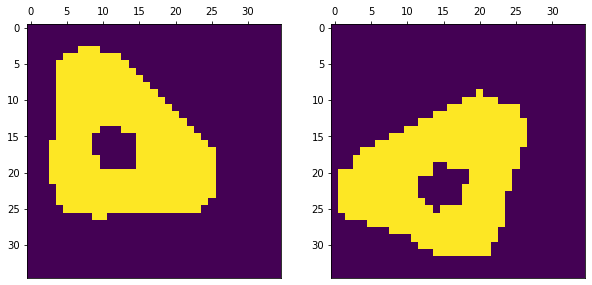

In [262]:
#########################################################
# Compute transformation matrix without matching points #
#########################################################

from scipy.optimize import minimize

def mse(params, source_img, target_img):
    # Create the affine transformation matrix
    a, b, c, d, tx, ty = params
    transformation_matrix = np.array([[a, b, tx],
                                      [c, d, ty],
                                      [0, 0, 1]])
    # Apply the affine transformation to the source image
    transformed_img = scipy.ndimage.affine_transform(source_img, transformation_matrix)
    # Compute the MSE between the transformed source image and the target image
    mse_value = np.mean((transformed_img - target_img)**2)
    # print(mse_value)
    return mse_value

# compute the Jacobian of the gradient
def jac(params, source_img, target_img):
    a, b, c, d, tx, ty = params
    # Compute the partial derivatives of the MSE with respect to each parameter
    dMSE_da = np.sum((source_img*a-target_img)*source_img)
    dMSE_db = np.sum((source_img*b-target_img)*source_img)
    dMSE_dc = np.sum((source_img*c-target_img)*source_img)
    dMSE_dd = np.sum((source_img*d-target_img)*source_img)
    dMSE_dtx = np.sum((source_img*tx-target_img)*source_img)
    dMSE_dty = np.sum((source_img*ty-target_img)*source_img)
    # Return the Jacobian matrix
    return np.array([dMSE_da, dMSE_db, dMSE_dc, dMSE_dd, dMSE_dtx, dMSE_dty])

# initial guess:
initial_guess = np.array([1, 0, 0, 1, 0, 0])

# perform the optimization
result = minimize(mse, initial_guess, args=(source_img, target_img), jac=jac,
                  method='BFGS', options={'gtol':1e-9, 'maxiter':10000})

###############################################################
# Apply the optimal affine transformation to the source image #
###############################################################
transformation_matrix = np.array([[result.x[0], result.x[1], result.x[4]],
                                  [result.x[2], result.x[3], result.x[5]],
                                  [0, 0, 1]])
source_img_tx3 = scipy.ndimage.affine_transform(source_img, transformation_matrix)

check_results(source_img_tx3, target_img)
